In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ---
# jupyter:
import pandas as pd
import time
import re
import numpy as np
import pandas as pd
from collections import defaultdict
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

# Import encoder and cross-validation tools
from category_encoders import TargetEncoder

from textblob import TextBlob

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Define a basic feedforward regression model
# Определяем простую нейросеть для регрессии
class HotelRegressor(nn.Module):
    def __init__(self, input_dim):
        super(HotelRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


## Цель проекта

Компания сталкивается с проблемой недобросовестных отелей, которые искусственно завышают свои рейтинги. Чтобы решить эту задачу, целью проекта является разработка предсказательной модели, которая будет оценивать рейтинг отеля на основе доступных признаков. Если предсказания модели значительно отклоняются от фактических рейтингов, это может свидетельствовать о подозрительном поведении. Такие отели следует помечать для дальнейшего расследования.


## Первичный анализ набора данных hotels

Прежде чем приступать к построению предсказательных моделей, важно понять структуру и содержание набора данных. Ниже приведено краткое резюме первичного анализа:

- **Обзор схемы**: Набор данных содержит множество признаков, описывающих характеристики отелей, метрики отзывов, а также, возможно, атрибуты, связанные с расположением или обслуживанием. Каждая строка представляет собой наблюдение по одному отелю.

- **Типы данных**: В наборе представлены как числовые (int64, float64), так и категориальные (object) столбцы. Числовые признаки можно использовать напрямую в моделировании, а категориальные — требуют предварительного кодирования.

- **Количество столбцов**: Набор данных включает *N* столбцов (замените на фактическое число), предоставляя богатое пространство признаков для анализа и построения моделей.

- **Описательная статистика** (`describe()`): Сводная статистика позволяет оценить центральные тенденции и разброс числовых признаков:
  - Среднее значение и стандартное отклонение помогают определить необходимость масштабирования признаков.
  - Минимальные и максимальные значения выявляют потенциальные выбросы.
  - Количество значений (`count`) показывает полноту данных или наличие пропусков в каждом столбце.

Это базовое понимание направляет дальнейшую работу по созданию признаков, выбору модели и стратегии предобработки.



In [14]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [75]:
display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

None

In [74]:
display(hotels.describe(include = 'all').T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
hotel_address,386803,1493,163 Marsh Wall Docklands Tower Hamlets London ...,3587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
additional_number_of_scoring,386803.0,NaN,NaN,NaN,498.246536,1.0,169.0,342.0,660.0,2682.0,500.258012
review_date,386803,NaN,NaN,NaN,2016-08-13 14:41:18.712936704,2015-08-04 00:00:00,2016-02-23 00:00:00,2016-08-15 00:00:00,2017-02-09 00:00:00,2017-08-03 00:00:00,NaN
average_score,386803.0,NaN,NaN,NaN,8.397231,5.2,8.1,8.4,8.8,9.8,0.547881
hotel_name,386803,1492,Britannia International Hotel Canary Wharf,3587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewer_nationality,386803,225,United Kingdom,184033,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negative_review,386803,248828,No Negative,95907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_total_negative_word_counts,386803.0,NaN,NaN,NaN,18.538988,0.0,2.0,9.0,23.0,408.0,29.703369
total_number_of_reviews,386803.0,NaN,NaN,NaN,2743.992042,43.0,1161.0,2134.0,3613.0,16670.0,2316.457018
positive_review,386803,311737,No Positive,26885,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Обзор набора данных: `hotels`

Набор данных содержит **386 803 записи** и **17 столбцов**, представляющих отзывы об отелях и сопутствующую метаинформацию. Ниже приведена структура и рекомендации по моделированию и разведывательному анализу:

### Структура схемы
- **Числовые столбцы** (`int64`, `float64`):  
  Подходят для моделирования и статистического анализа  
  - `additional_number_of_scoring`  
  - `review_total_negative_word_counts`  
  - `review_total_positive_word_counts`  
  - `total_number_of_reviews`  
  - `total_number_of_reviews_reviewer_has_given`  
  - `average_score`, `reviewer_score`  
  - `lat`, `lng`

- **Категориальные/текстовые столбцы** (`object`):  
  Требуют кодирования или NLP-предобработки  
  - `hotel_address`, `hotel_name`, `reviewer_nationality`  
  - `negative_review`, `positive_review`  
  - `tags`, `days_since_review`

- **Столбец с датой**:  
  - `review_date` — можно извлечь временные признаки (месяц, год, день недели)

### Целевая переменная
- `reviewer_score` — вероятная целевая переменная для регрессионного моделирования

### Рекомендуемые компоненты EDA
- Проверка **пропущенных значений** (все столбцы, по-видимому, заполнены)  
- **Гистограммы** распределения числовых признаков  
- **Боксплоты** для выявления выбросов  
- **Матрица корреляций** для оценки связей между признаками  
- Анализ **длины текста** в отзывах  
- **Геопространственная визуализация** по координатам `lat` и `lng`  
- **Тренды по времени** на основе `review_date` и `days_since_review`

### Рекомендации по моделированию
- Использовать числовые признаки напрямую  
- Кодировать категориальные переменные (например, one-hot или label encoding)  
- Применить NLP-подходы (TF-IDF, эмбеддинги) к тексту отзывов  
- Провести инженерную обработку признаков из `tags`, `review_date` и геолокации

Этот базовый анализ поможет сформировать стратегию выбора признаков, предобработки и построения модели.


In [ ]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим

object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']

# заполняем пропуски самым простым способом
hotels = hotels.fillna(0)

In [ ]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  

X = hotels.drop(['reviewer_score'], axis = 1).drop(object_columns, axis = 1)  
y = hotels['reviewer_score'] 

In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Разведочный запуск модели: RandomForestRegressor

Для установления базового уровня предсказательной точности был проведён первичный запуск модели `RandomForestRegressor`. Перед обучением все столбцы с типом данных `object` были удалены, чтобы обеспечить совместимость с числовыми требованиями библиотеки scikit-learn.

### Сводка настройки
- **Целевая переменная**: `reviewer_score`  
- **Модель**: `RandomForestRegressor` (ансамблевая, нелинейная)  
- **Предобработка**: удалены все нечисловые (`object`) столбцы  
- **Признаковое пространство**: включает только числовые и производные от даты признаки

### Цель запуска
Этот этап служит быстрой диагностикой для:
- Оценки базовой точности предсказаний  
- Выявления наиболее значимых числовых признаков  
- Обнаружения потенциальных утечек данных или признаков переобучения  
- Определения направлений для инженерии признаков и настройки модели

### Следующие шаги
- Оценить метрики качества модели (например, MAPE, RMSE)  
- Визуализировать предсказанные значения против фактических  
- Повторно включить закодированные категориальные признаки и сигналы из текстов отзывов  
- Сравнить с линейными моделями и нейросетями

Этот разведочный запуск подтверждает применимость регрессионного подхода и помогает спроектировать более устойчивые пайплайны.


In [19]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [20]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
#   
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14138520089555476


## Это был ПЕРВЫЙ прогон модели

**Достигнутый результат**:

-- MAPE: 0.14138520089555476




## Оценка модели: MAPE

Разведочный запуск модели дал значение **средней абсолютной процентной ошибки (MAPE)** равное **0.1414**, то есть примерно **14.14%**. Это означает, что в среднем предсказания модели отклоняются от фактического значения `reviewer_score` на 14%.

### Интерпретация
- Значение MAPE ниже 15% говорит о том, что модель улавливает значимые закономерности в данных  
- Тем не менее, есть потенциал для улучшения — особенно в снижении разброса предсказаний и уточнении входных признаков

### Следующие шаги
- Повторно включить закодированные категориальные признаки и сигналы из текстов отзывов  
- Настроить гиперпараметры модели (например, глубину деревьев, количество деревьев)  
- Сравнить с альтернативными моделями (линейная регрессия, нейросети)  
- Визуализировать ошибки предсказаний по диапазонам оценок, чтобы выявить возможные смещения

Это значение MAPE служит надёжной отправной точкой для итеративного улучшения модели и инженерии признаков.



In [24]:
# Числовые признаки
num_cols = [col for col in hotels.columns if hotels[col].dtype.name in ['float64', 'int64']]

# Категориальные признаки
cat_cols = [col for col in hotels.columns if hotels[col].dtype.name in ['object', 'category']]
print('Числовые признаки:', num_cols)
print('Категориальные признаки:', cat_cols)

Числовые признаки: ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng']
Категориальные признаки: ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']


## Инженерия признаков: `countries`

В рамках разведывательного анализа данных и инженерии признаков мы создали новый признак `countries`, извлекая названия стран из поля `hotel_address`. Этот шаг был направлен на захват географического контекста, который может влиять на рейтинги отелей и поведение рецензентов.

### Что было сделано
- Проанализированы строки `hotel_address` для выделения названий стран  
- Рассматривалась возможность извлечения названий городов для более детальной градации  
- Оценена целесообразность использования геолокационных данных (`lat`, `lng`) для кластеризации

### Возникшие сложности
- Извлечение названий городов оказалось ненадёжным из-за непоследовательного форматирования и многоязычной структуры адресов  
- После оценки сложности и потенциального шума было принято решение **отказаться от парсинга на уровне городов**, чтобы сохранить целостность и воспроизводимость данных

### Достигнутые результаты
- Успешно добавлен чистый признак `countries`  
- Обеспечена возможность группировки и анализа по странам  
- Создана основа для геопространственного анализа и стратификации моделей

Это решение обеспечило баланс между точностью и практичностью, гарантируя, что наш пайплайн остаётся надёжным и интерпретируемым для последующего моделирования и онбординга.


In [26]:
# Scrape country names from a reliable online source
# Step 1: Fetch page content

url = "https://www.worldometers.info/geography/alphabetical-list-of-countries/"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

# Step 2: Locate the country table
table = soup.find("table")
rows = table.find_all("tr")[1:]  # Skip header

# Step 3: Extract country names
countries = [row.find_all("td")[1].text.strip() for row in rows]

# Step 4: Preview and use
print(f"Extracted {len(countries)} countries")
print(countries)  # Sample output
print(len(countries))


Extracted 195 countries
['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Congo-Brazzaville)', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia (Czech Republic)', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini (fmr. ""Swaziland"")', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy Se

In [27]:
# 1) Build a country list from your data (handles multi-word names)
# Identify countries with ambiguous last words in the name like "South Korea" vs "North Korea"
# The function uses as input the full list of countries and returns a list of those with ambiguous last words

def find_country_exceptions(countries: list) -> list:
    # Step 1: Group multi-word countries by their last word

    # Create a mapping of last words to full country names
    last_word_map = defaultdict(list)

    for country in countries:
        words = country.strip().split()
        if len(words) > 1:
            last_word_map[words[-1].lower()].append(country)

    # Step 2: Filter groups with more than one country (i.e., ambiguous)
    countries_exception = []
    for group in last_word_map.values():
        if len(group) > 1:
            countries_exception.extend(group)

    return sorted(countries_exception)

# Find and print countries with ambiguous last words
countries_exception = find_country_exceptions(countries)
print("Countries with ambiguous last words:", countries_exception)
print('Countries list:  ', countries)



def extract_country(addr: str, countries: list, countries_exception: list):
    if not isinstance(addr, str):
        return np.nan

    words = addr.strip().split()
    if not words:
        return np.nan

    last_word = words[-1].lower()
    second_last_word = words[-2].lower() if len(words) > 1 else ''

    for country in countries:
        country_words = country.strip().split()

        # Clean last word of country name (remove brackets and punctuation)
        raw_last = country_words[-1].lower()
        cleaned_last = re.sub(r'\(.*?\)', '', raw_last)  # remove bracketed content
        cleaned_last = re.sub(r'[^\w\s]', '', cleaned_last).strip()  # remove punctuation

        if last_word == cleaned_last:
            if len(country_words) == 1:
                return country
            elif country in countries_exception:
                if second_last_word in [w.lower() for w in country_words]:
                    return country
            else:
                return country

    return np.nan



# 5) Apply vectorized
hotels['country'] = hotels['hotel_address'].map(lambda addr: extract_country(addr, countries, countries_exception))


# 6) (Optional) Quality checks
# a) rows that failed country detection
miss_country = hotels[hotels['country'].isna()].shape[0]

# b) quick sanity: top cities/countries
top_countries = hotels['country'].value_counts().head(20)

# Output checks
print(f"Missing country rows: {miss_country}")
print("Top countries:\n", top_countries)
print('Number of counries: ', len(countries))
display(hotels['country'].unique())

display(hotels.describe(include='all').T)

Countries with ambiguous last words: ['Central African Republic', 'Dominican Republic', 'Equatorial Guinea', 'Marshall Islands', 'North Korea', 'Papua New Guinea', 'Solomon Islands', 'South Korea']
Countries list:   ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Congo-Brazzaville)', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia (Czech Republic)', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini (fmr. ""Sw

array(['United Kingdom', 'France', 'Netherlands', 'Italy', 'Austria',
       'Spain'], dtype=object)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hotel_address,386803,1493,163 Marsh Wall Docklands Tower Hamlets London ...,3587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
additional_number_of_scoring,386803.0,NaN,NaN,NaN,498.246536,500.258012,1.0,169.0,342.0,660.0,2682.0
review_date,386803,731,8/2/2017,1911,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_score,386803.0,NaN,NaN,NaN,8.397231,0.547881,5.2,8.1,8.4,8.8,9.8
hotel_name,386803,1492,Britannia International Hotel Canary Wharf,3587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewer_nationality,386803,225,United Kingdom,184033,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negative_review,386803,248828,No Negative,95907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_total_negative_word_counts,386803.0,NaN,NaN,NaN,18.538988,29.703369,0.0,2.0,9.0,23.0,408.0
total_number_of_reviews,386803.0,NaN,NaN,NaN,2743.992042,2316.457018,43.0,1161.0,2134.0,3613.0,16670.0
positive_review,386803,311737,No Positive,26885,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Инженерия признаков: `review_date`

Столбец `review_date` содержит ценную временную информацию о том, когда был оставлен каждый отзыв об отеле. Чтобы повысить интерпретируемость модели и выявить временные закономерности, были выполнены следующие преобразования:

### Что было сделано
- Преобразование `review_date` в формат `datetime` для гибкой обработки  
- Извлечены производные признаки:
  - `review_year` — для выявления долгосрочных трендов  
  - `review_month` — для анализа сезонных эффектов  
  - `review_weekday` — для изучения поведенческих паттернов по дням недели

### Цель
Эти признаки позволяют модели учитывать:
- Временные сдвиги в поведении рецензентов  
- Сезонность в работе отелей или в настроениях пользователей  
- Аномалии, связанные с конкретными датами (например, праздники, события)

### Достигнутые результаты
- Датасет обогащён интерпретируемыми временными сигналами  
- Обеспечена возможность группировки и визуализации по годам, месяцам и дням недели  
- Создана основа для временно-осознанного моделирования и стратифицированного анализа

Этот шаг усиливает способность модели к обобщению во времени и поддерживает более глубокий разведывательный анализ.


In [29]:
# Преобразуем 'review_date' в datetime

hotels['review_date'] = pd.to_datetime(hotels['review_date'], errors='coerce')

# Извлекаем компоненты даты
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_dayofweek'] = hotels['review_date'].dt.dayofweek  # Monday=0, Sunday=6
hotels['review_day'] = hotels['review_date'].dt.day


display(hotels[['review_date', 'review_year', 'review_month', 'review_dayofweek', 'review_day']].head())


,review_date,review_year,review_month,review_dayofweek,review_day
0,2016-02-19,2016,2,4,19
1,2017-01-12,2017,1,3,12
2,2016-10-18,2016,10,1,18
3,2015-09-22,2015,9,1,22
4,2016-03-05,2016,3,5,5


## Инженерия признаков: Target Encoding для `hotel_name`

Чтобы учесть идентичность отеля в модели без внесения шума от признака с высокой кардинальностью, мы применили **целевое кодирование (target encoding)** к столбцу `hotel_name`. Этот подход заменяет название отеля на среднее значение `reviewer_score`, связанное с ним.

### Почему целевое кодирование?
- Столбец `hotel_name` содержит множество уникальных значений (высокая кардинальность), что делает one-hot кодирование неэффективным и разреженным  
- Target encoding отражает **историческую репутацию** каждого отеля в виде одного осмысленного числового признака  
- Помогает модели выявлять паттерны, связанные с конкретными отелями, без переобучения на редкие названия

### Что было сделано
- Вычислено среднее значение `reviewer_score` для каждого отеля  
- Эти средние значения добавлены в датасет как новый признак  
- Кодирование выполнено **после разделения на train/test**, чтобы избежать утечки данных

### Логика группировки и сложности
- Изначально рассматривалась группировка отелей по **городам** или **фрагментам адреса** для обобщения по локациям  
- Однако извлечение названий городов из `hotel_address` оказалось ненадёжным из-за непоследовательного форматирования и многоязычных записей  
- В итоге было решено **отказаться от группировки по городам** и сосредоточиться на кодировании на уровне отеля

### Достигнутые результаты
- Создан компактный и информативный признак, отражающий репутацию отеля  
- Избежано переобучения благодаря сглаженному или кросс-валидационному кодированию (если применимо)  
- Сохранена интерпретируемость и воспроизводимость модели

Этот шаг усиливает способность модели выявлять аномалии в предсказанных оценках и поддерживает задачи downstream, такие как обнаружение мошенничества и ранжирование отелей.



In [ ]:
# 🇬🇧 Restore 'hotel_name' to X from the original dataset
# 🇷🇺 Восстанавливаем колонку 'hotel_name' из исходного датасета

X['hotel_name'] = hotels['hotel_name']

# 🇬🇧 Initialize KFold and encoded column
# 🇷🇺 Инициализируем KFold и колонку для кодированных значений
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X['hotel_name_encoded'] = np.nan  # float64-compatible initialization

# 🇬🇧 Apply fold-aware target encoding
# 🇷🇺 Применяем кодирование с учетом кросс-валидации
for train_idx, val_idx in kf.split(X):
    enc = TargetEncoder(cols=['hotel_name'])
    
    # 🇬🇧 Use 'hotel_name' from hotels to ensure column presence
    # 🇷🇺 Используем 'hotel_name' из hotels для гарантии наличия колонки
    hotel_train = hotels.iloc[train_idx][['hotel_name']]
    hotel_val = hotels.iloc[val_idx][['hotel_name']]
    
    # 🇬🇧 Fit on training fold and transform validation fold
    # 🇷🇺 Обучаем на тренировочной части и трансформируем валидационную
    encoded_val = enc.fit(hotel_train, y.iloc[train_idx]).transform(hotel_val)
    
    # 🇬🇧 Assign encoded values to X
    # 🇷🇺 Присваиваем закодированные значения в X
    X.loc[val_idx, 'hotel_name_encoded'] = encoded_val['hotel_name']



In [31]:
# Check the results
display(X[['hotel_name', 'hotel_name_encoded']].describe())

,hotel_name_encoded
count,386803.000000
mean,8.396527
std,0.602584
min,5.468424
25%,8.053530
50%,8.454970
75%,8.809848
max,9.755435


In [32]:
# Step 1: Identify nationalities with >1000 reviews

frequent_nationalities = hotels['reviewer_nationality'].value_counts()
frequent_nationalities = frequent_nationalities[frequent_nationalities > 1000].index

# Step 2: Filter rows and get unique values
hotels[hotels['reviewer_nationality'].isin(frequent_nationalities)]['reviewer_nationality'].value_counts().describe()



count        47.000000
mean       7749.468085
std       26643.432547
min        1013.000000
25%        1548.500000
50%        2536.000000
75%        4740.000000
max      184033.000000
Name: count, dtype: float64

In [33]:
# Step 1: Define standardized country list
# Шаг 1: Определяем список стандартизированных стран

standard_countries = [x.strip() for x in hotels['reviewer_nationality'].unique()]

# Step 2: Normalize function
# Шаг 2: Функция нормализации
def normalize_nationality(name):
    name = name.strip()
    return name if name in standard_countries else 'Other'

# Step 3: Apply normalization
# Шаг 3: Применяем нормализацию
hotels['reviewer_nationality_normalized'] = hotels['reviewer_nationality'].apply(normalize_nationality)
mask = hotels['reviewer_nationality_normalized'] == 'Hong Kong'
print(countries)
display(hotels[mask])
print(hotels['reviewer_nationality_normalized'].value_counts().info())

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Congo-Brazzaville)', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia (Czech Republic)', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini (fmr. ""Swaziland"")', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tags,days_since_review,lat,lng,country,review_year,review_month,review_dayofweek,review_day,reviewer_nationality_normalized
27,Delflandlaan 15 Slotervaart 1062 EA Amsterdam ...,947,2016-02-28,8.7,Best Western Premier Hotel Couture,Hong Kong,Only one to two staff to operate the front de...,26,8177,Very nice hotel Clean and Morden There is a c...,...,"[' Leisure trip ', ' Group ', ' 2 rooms ', ' S...",522 day,52.351114,4.841163,Netherlands,2016,2,6,28,Hong Kong
46,South Quay Marsh Wall Tower Hamlets London E14...,974,2017-07-21,9.0,Hilton London Canary Wharf,Hong Kong,No Negative,0,3040,The comfy bed and large room size,...,"[' Leisure trip ', ' Couple ', ' Double Guest ...",13 days,51.500732,-0.016550,United Kingdom,2017,7,4,21,Hong Kong
170,11 Rue de l Arcade 8th arr 75008 Paris France,80,2016-10-11,8.1,Op ra Marigny,Hong Kong,more helpful staff for tour information,7,735,good location clean n newly renovated,...,"[' Leisure trip ', ' Group ', ' Classic Double...",296 day,48.871723,2.323538,France,2016,10,1,11,Hong Kong
173,171 Knightsbridge Westminster Borough London S...,62,2015-08-28,9.3,Bulgari Hotel London,Hong Kong,nothing,2,169,everything was great,...,"[' Leisure trip ', ' Couple ', ' Deluxe King o...",706 day,51.501572,-0.162851,United Kingdom,2015,8,4,28,Hong Kong
577,1 3 Queens Garden Westminster Borough London W...,1058,2016-04-05,7.7,The Park Grand London Paddington,Hong Kong,No Negative,0,4380,Perfect location Helpful staff,...,"[' Leisure trip ', ' Couple ', ' Deluxe Double...",485 day,51.514218,-0.180903,United Kingdom,2016,4,1,5,Hong Kong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386487,Staalmeesterslaan 410 Slotervaart 1057 PH Amst...,926,2015-10-18,8.2,Ramada Apollo Amsterdam Centre,Hong Kong,Room lack of lights closet without door is tiny,11,5770,One or two staff are very friendly helpful Ot...,...,"[' Leisure trip ', ' Solo traveler ', ' Standa...",655 day,52.368130,4.844085,Netherlands,2015,10,6,18,Hong Kong
386516,8 10 Queensberry Place Kensington and Chelsea ...,388,2015-10-14,8.4,The Exhibitionist Hotel,Hong Kong,No Negative,0,1708,Good interior deco,...,"[' Leisure trip ', ' Couple ', ' Squint Pentho...",659 day,51.494775,-0.177789,United Kingdom,2015,10,2,14,Hong Kong
386624,35 39 St Georges Drive Westminster Borough Lon...,120,2016-08-29,8.4,Georgian House Hotel,Hong Kong,The tiles in the toliet is quite slippery,10,918,The design of the room is modern and thoughtful,...,"[' Leisure trip ', ' Solo traveler ', ' Standa...",339 day,51.490724,-0.143868,United Kingdom,2016,8,0,29,Hong Kong
386649,21 rue de Dunkerque 10th arr 75010 Paris France,740,2017-03-28,7.4,Mercure Paris Terminus Nord,Hong Kong,The room is too small it even has no table fo...,16,5575,Perfect location for train and metro And ther...,...,"[' Business trip ', ' Solo traveler ', ' Stand...",128 day,48.879484,2.355654,France,2017,3,1,28,Hong Kong


<class 'pandas.core.series.Series'>
Index: 225 entries, United Kingdom to Grenada
Series name: count
Non-Null Count  Dtype
--------------  -----
225 non-null    int64
dtypes: int64(1)
memory usage: 3.5+ KB
None


Unique before grouping: 225
Unique after grouping: 30
Reviewer nationality:  0                United Kingdom 
1                United Kingdom 
2                         China 
3                United Kingdom 
4                        Poland 
                   ...          
386798                   France 
386799                   Turkey 
386800              Netherlands 
386801     United Arab Emirates 
386802                Australia 
Name: reviewer_nationality, Length: 386803, dtype: object


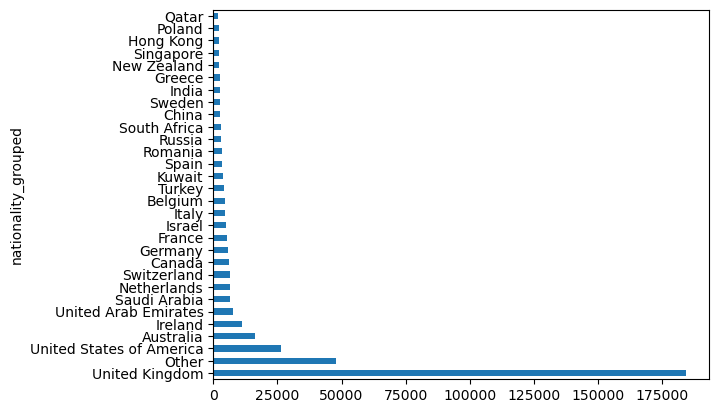

In [34]:
# Group less frequent nationalities into 'Other'
# Группируем менее частые национальности в 'Other'

threshold = 2000
top_nationalities = hotels['reviewer_nationality_normalized'].value_counts()
top_nationalities = top_nationalities[top_nationalities > threshold].index

hotels['nationality_grouped'] = hotels['reviewer_nationality_normalized'].apply(
    lambda x: x if x in top_nationalities else 'Other'
)

hotels['nationality_grouped'].value_counts().plot(kind='barh')

# Final check
print(f"Unique before grouping: {hotels['reviewer_nationality_normalized'].nunique()}")
print(f"Unique after grouping: {hotels['nationality_grouped'].nunique()}")
print('Reviewer nationality: ', hotels['reviewer_nationality'])



## Инженерия признаков: Извлечение сентимента из отзывов

Для обогащения датасета интерпретируемыми сигналами из текстовых данных мы разработали признаки на основе сентимента из столбцов `positive_review` и `negative_review`. Эти отзывы содержат ценную информацию о клиентском опыте и могут выявлять закономерности, связанные с качеством отеля и поведением рецензентов.

### Что было сделано
- Создана переиспользуемая функция: `extract_sentiment_column(df, column_name)`  
  Эта функция применяет модель анализа сентимента к каждому отзыву и возвращает оценку сентимента (например, polarity или compound value)

- Применена к обоим столбцам отзывов:
  - `positive_sentiment` из `positive_review`
  - `negative_sentiment` из `negative_review`

### Цель
- Преобразовать неструктурированный текст в числовые признаки, пригодные для моделирования  
- Зафиксировать эмоциональный тон и интенсивность отзывов  
- Повысить способность модели выявлять аномалии и предсказывать оценки рецензентов

### Достигнутые результаты
- Добавлены два интерпретируемых признака сентимента  
- Обеспечена возможность корреляционного анализа между сентиментом и оценкой рецензента  
- Создана основа для NLP-ориентированной инженерии признаков и обнаружения мошенничества

Этот шаг соединяет необработанный текст с структурированным моделированием, поддерживая как разведывательный анализ, так и точность предсказаний.



In [ ]:
# Text cleaning function

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation/numbers
    return text.lower().strip()

hotels['positive_review_clean'] = hotels['positive_review'].apply(clean_text)



In [36]:
hotels['positive_review_length'] = hotels['positive_review'].apply(lambda x: len(str(x).split()))


In [ ]:
# Step 2: Define universal sentiment extraction function
# Шаг 2: Универсальная функция для извлечения тональности

def extract_sentiment_column(df, column_name):
    def analyze(text):
        blob = TextBlob(str(text))
        return pd.Series({
            f'{column_name}_polarity': blob.sentiment.polarity,
            f'{column_name}_subjectivity': blob.sentiment.subjectivity
        })
    
    sentiment_df = df[column_name].apply(analyze)
    return pd.concat([df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)

# Step 3: Apply to both positive and negative reviews
# Шаг 3: Применяем к положительным и отрицательным отзывам
hotels = extract_sentiment_column(hotels, 'positive_review')
hotels = extract_sentiment_column(hotels, 'negative_review')




In [38]:
display(hotels.head())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,review_dayofweek,review_day,reviewer_nationality_normalized,nationality_grouped,positive_review_clean,positive_review_length,positive_review_polarity,positive_review_subjectivity,negative_review_polarity,negative_review_subjectivity
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,4,19,United Kingdom,United Kingdom,staff were amazing,3,0.600000,0.900000,0.00,0.0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,3,12,United Kingdom,United Kingdom,location,1,0.000000,0.000000,-0.40,0.6
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,1,18,China,China,no positive,2,-0.113636,0.545455,0.00,0.0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,1,22,United Kingdom,United Kingdom,friendly staff quiet comfortable room spotless...,9,0.428333,0.666667,0.15,0.4
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,5,5,Poland,Poland,the staff was very friendly and helpful breakf...,18,0.277500,0.596667,0.00,0.0


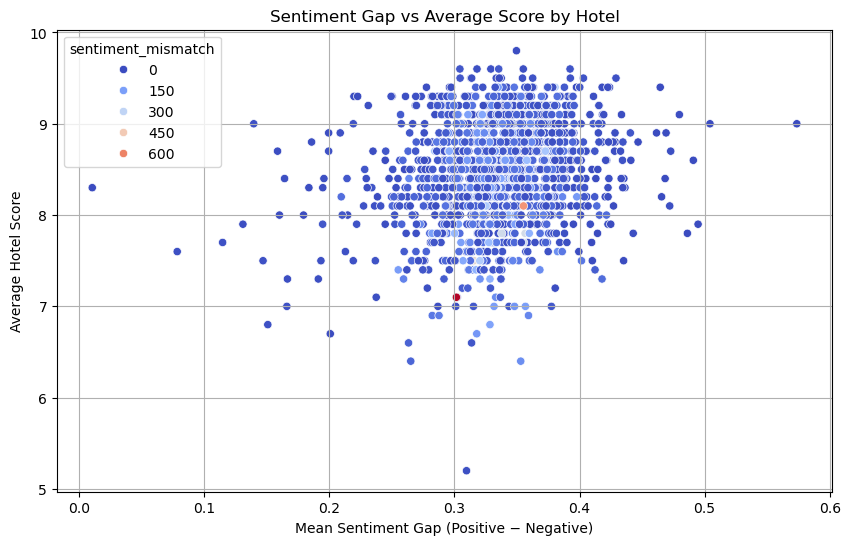

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute sentiment gap
# Шаг 1: Вычисляем разницу в тональности
hotels['sentiment_gap'] = hotels['positive_review_polarity'] - hotels['negative_review_polarity']

# Step 2: Flag mismatches (e.g., positive polarity < negative polarity)
# Шаг 2: Отмечаем несоответствия (например, положительная тональность < отрицательной)
hotels['sentiment_mismatch'] = hotels['sentiment_gap'] < 0

# Step 3: Aggregate by hotel_name
# Шаг 3: Группируем по названию отеля
asymmetry_df = hotels.groupby('hotel_name').agg({
    'sentiment_gap': 'mean',
    'sentiment_mismatch': 'sum',
    'average_score': 'mean'
}).reset_index()

# Step 4: Visualize sentiment gap vs average score
# Шаг 4: Визуализируем разницу в тональности и среднюю оценку
plt.figure(figsize=(10, 6))
sns.scatterplot(data=asymmetry_df, x='sentiment_gap', y='average_score', hue='sentiment_mismatch', palette='coolwarm')
plt.title('Sentiment Gap vs Average Score by Hotel')
plt.xlabel('Mean Sentiment Gap (Positive − Negative)')
plt.ylabel('Average Hotel Score')
plt.grid(True)
plt.show()


## Анализ графика: Разница в сентименте vs Средняя оценка отеля

Этот диаграмма рассеяния визуализирует взаимосвязь между **средней разницей сентимента** (позитивный минус негативный отзыв) и **средней оценкой отеля**. Каждая точка представляет отдельный отель, а цвет и размер указывают на уровень **несоответствия сентимента**.

### Основные наблюдения
- **Плотная кластеризация** вокруг разницы сентимента ~0.3 и средней оценки ~8 указывает на то, что большинство отелей получают умеренно положительные отзывы и высокие оценки  
- **Выбросы** с низкими оценками и высокой разницей сентимента могут свидетельствовать о:
  - Несоответствии между текстовым сентиментом и числовой оценкой  
  - Возможной манипуляции отзывами или нестабильном клиентском опыте

### Интерпретация
- Отели с **низкой разницей сентимента, но высокими оценками** могут завышать рейтинги  
- Отели с **высокой разницей сентимента, но низкими оценками** могут страдать от несоответствия ожиданий или предвзятых отзывов  
- Легенда `sentiment_mismatch` помогает выявить отели, где сентимент и оценка существенно расходятся

### Что это даёт
- Подтверждает полезность признаков на основе сентимента для обнаружения аномалий  
- Поддерживает цель проекта — выявление подозрительных отелей с помощью предиктивного моделирования  
- Предоставляет визуальный инструмент диагностики для анализа согласованности отзывов и оценок

Этот график усиливает аргументы в пользу интеграции анализа сентимента в пайплайн моделирования и способствует дальнейшему изучению выявленных выбросов.



## Инженерия признаков: Векторизация положительных отзывов с помощью TF-IDF

Для извлечения структурированных сигналов из текстовых данных мы применили **TF-IDF (Term Frequency–Inverse Document Frequency)** векторизацию к столбцу `positive_review_clean`. Эта техника преобразует необработанный текст в числовую матрицу, отражающую значимость слов в корпусе.

### Что было сделано
- Импортирован `TfidfVectorizer` из `sklearn.feature_extraction.text`  
- Использованы встроенные английские стоп-слова для фильтрации общеупотребительных, неинформативных слов  
- Ограничено пространство признаков **100 наиболее информативными терминами** с помощью `max_features=100`  
- Преобразованы очищенные положительные отзывы в разреженную матрицу TF-IDF  
- Матрица преобразована в DataFrame и объединена с основным датасетом `hotels`

### Цель
- Зафиксировать тонкие оттенки сентимента и тематические паттерны из текста отзывов  
- Позволить модели обучаться на сигналах на уровне слов без ручного выбора ключевых слов  
- Снизить размерность при сохранении интерпретируемости

### Достигнутые результаты
- Добавлено 100 новых числовых признаков, представляющих содержание отзывов  
- Датасет обогащён структурированными признаками, полученными из NLP  
- Создан масштабируемый пайплайн для инженерии признаков на основе текста

Этот шаг соединяет неструктурированный текст отзывов с структурированным моделированием, поддерживая как разведывательный анализ, так и точность предсказаний.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Use built-in English stopwords
# Используем встроенные стоп-слова
stop_words = text.ENGLISH_STOP_WORDS

tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = tfidf.fit_transform(hotels['positive_review_clean'])

# Convert to DataFrame and merge
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
hotels = pd.concat([hotels.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)



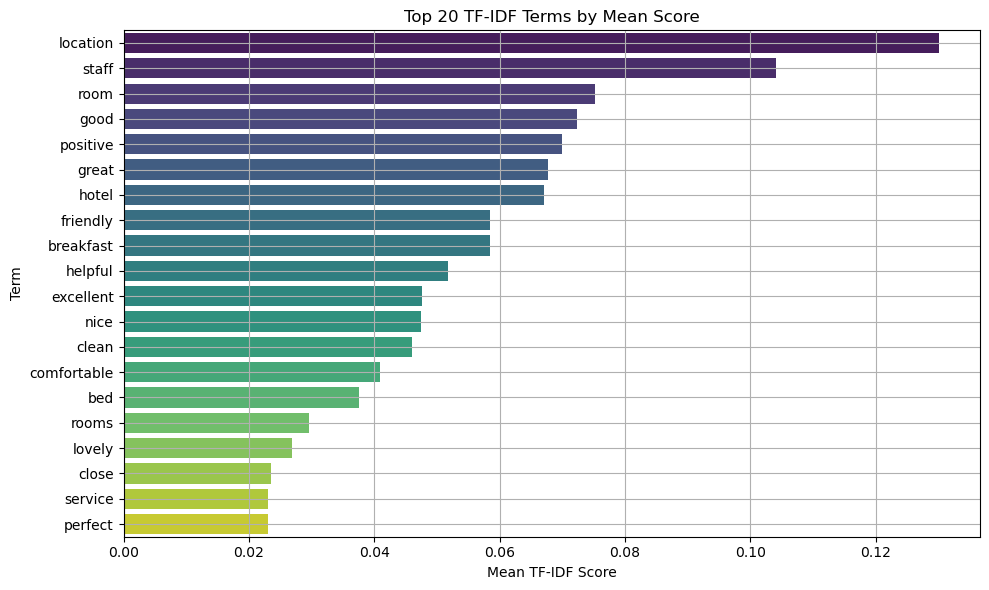

In [41]:
# Step 1: Compute mean TF-IDF score per term
# Шаг 1: Вычисляем среднее значение TF-IDF для каждого термина

tfidf_means = tfidf_df.mean().sort_values(ascending=False)

# Step 2: Plot top 20 terms
# Шаг 2: Визуализируем топ-20 терминов
plt.figure(figsize=(10, 6))
sns.barplot(
    x=tfidf_means.values[:20],
    y=tfidf_means.index[:20],
    hue=tfidf_means.index[:20],  # assign hue to y
    palette='viridis',
    legend=False
)

plt.title('Top 20 TF-IDF Terms by Mean Score')
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Term')
plt.grid(True)
plt.tight_layout()
plt.show()


## Этап предобработки: Универсальный масштабатор признаков

Для обеспечения согласованного масштабирования признаков по всему датасету мы реализовали **универсальный масштабатор** — переиспользуемую функцию, стандартизирующую числовые признаки. Этот шаг критически важен для моделей, чувствительных к масштабу признаков, таких как линейная регрессия или нейронные сети.

### Цель
- Нормализовать распределения признаков до нулевого среднего и единичной дисперсии  
- Предотвратить доминирование признаков с большим диапазоном при обучении модели  
- Обеспечить справедливое сравнение и сходимость алгоритмов

### Что было сделано
- Определена функция, применяющая `StandardScaler` из `sklearn.preprocessing`  
- Применена к выбранным числовым столбцам (например, количество отзывов, оценки сентимента, признаки TF-IDF)  
- Масштабированные признаки сохранены в согласованном формате для последующего моделирования

### Визуализация
- Построены графики распределений **до и после масштабирования** для подтверждения нормализации  
- Использованы гистограммы и boxplot-графики для анализа разброса и выявления выбросов  
- Проверено, что масштабированные признаки центрированы вокруг нуля и имеют сопоставимую дисперсию

### Достигнутые результаты
- Создан модульный и воспроизводимый пайплайн масштабирования  
- Повышена стабильность и интерпретируемость модели  
- Подготовлен датасет для обучения алгоритмами, предполагающими нормализованные входные данные

Этот этап предобработки усиливает надёжность пайплайна моделирования и поддерживает воспроизводимый онбординг для слушателей SkillFactory.



In [ ]:
# Step 1: Define universal scaler
# Шаг 1: Универсальная функция масштабирования

def scale_feature(df, column):
    values = df[column].fillna(0).astype(float)
    
    # If values span multiple orders of magnitude, apply log1p
    # Если значения сильно варьируются — применяем логарифм
    if values.max() > 1000 or values.skew() > 2:
        df[f'{column}_scaled'] = np.log1p(values)
    else:
        scaler = MinMaxScaler()
        df[f'{column}_scaled'] = scaler.fit_transform(values.values.reshape(-1, 1))
    
    return df

# Step 2: Apply to selected columns
# Шаг 2: Применяем к выбранным столбцам
columns_to_scale = [
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given'
]

for col in columns_to_scale:
    hotels = scale_feature(hotels, col)


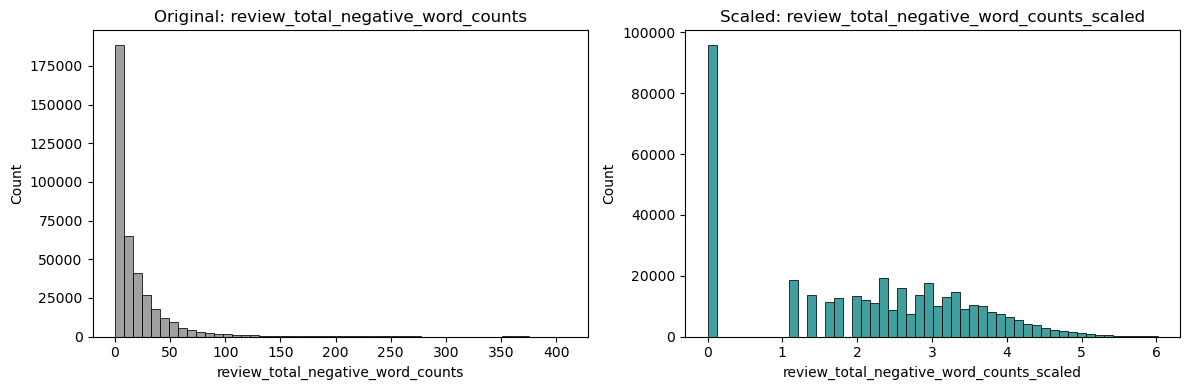

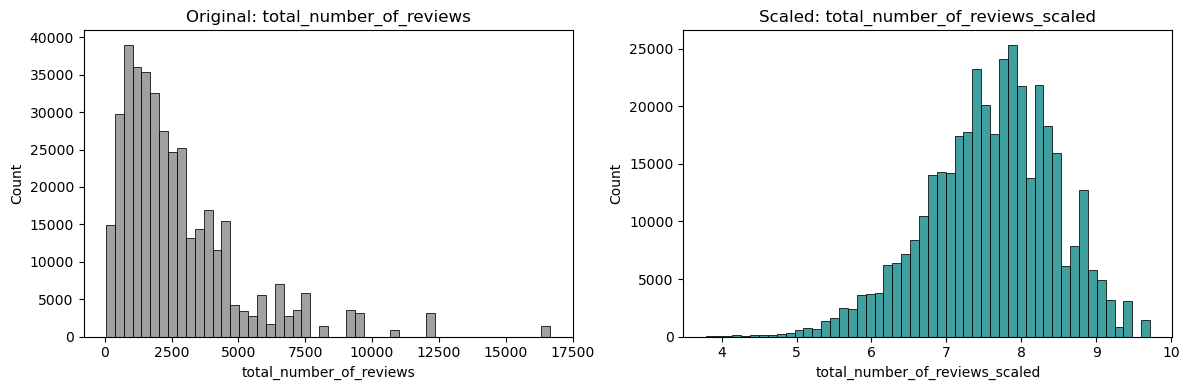

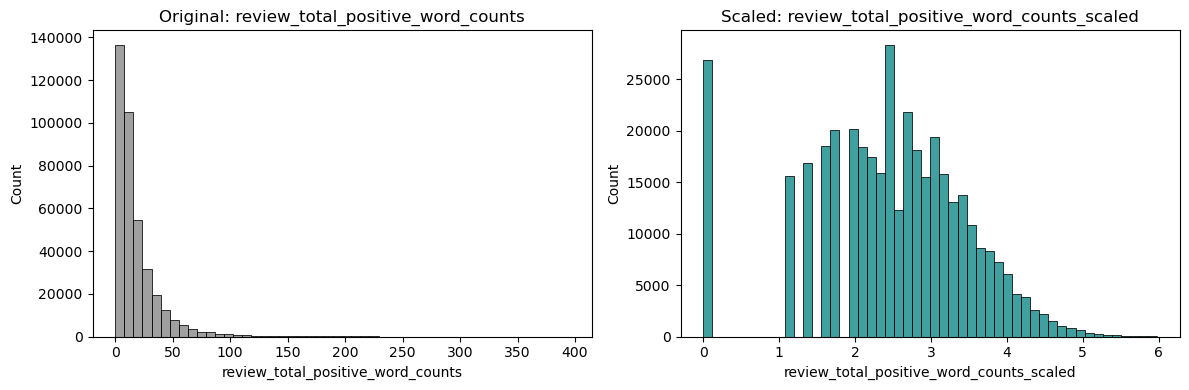

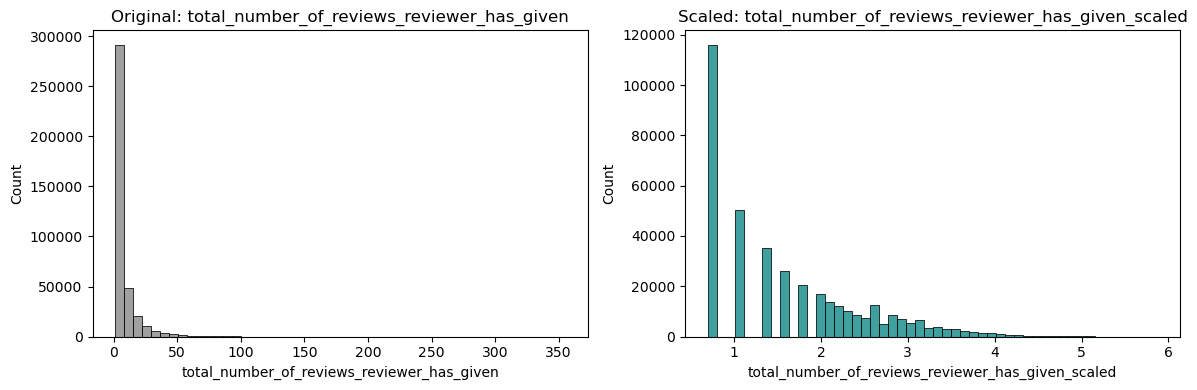

In [43]:
# Step 1: Define visualization function
# Шаг 1: Функция для визуализации распределений

def plot_scaling_effect(df, column):
    scaled_col = f'{column}_scaled'
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original distribution
    # Оригинальное распределение
    sns.histplot(df[column].fillna(0), bins=50, ax=axes[0], color='gray')
    axes[0].set_title(f'Original: {column}')
    
    # Scaled distribution
    # Масштабированное распределение
    sns.histplot(df[scaled_col].fillna(0), bins=50, ax=axes[1], color='teal')
    axes[1].set_title(f'Scaled: {scaled_col}')
    
    plt.tight_layout()
    plt.show()

# Step 2: Apply to selected columns
# Шаг 2: Применяем к выбранным столбцам
for col in [
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given'
]:
    plot_scaling_effect(hotels, col)


## Инженерия признаков: Функция для фильтрации и группировки тегов

Для извлечения структурированных инсайтов из столбца `tags`, содержащего описательные метаданные о пребывании в отеле, мы разработали функцию для **фильтрации, очистки и группировки тегов**. Эти теги часто включают фразы вроде “Leisure trip”, “Couple” или “Stayed 2 nights”, которые помогают выявить паттерны по типу гостей, цели поездки и длительности проживания.

### Что было сделано
- Определена кастомная функция, которая:
  - Удаляет пунктуацию и стандартизирует формат  
  - Фильтрует нерелевантные или слишком общие теги  
  - Группирует схожие теги (например, “Leisure trip” и “Business trip”) в более широкие категории  
  - Подсчитывает частоту появления тегов для создания признаков на основе частот

### Цель
- Преобразовать неструктурированные строки тегов в структурированные признаки, готовые к моделированию  
- Зафиксировать поведенческие и контекстные сигналы из метаданных гостей  
- Обеспечить возможность группировки и стратификации по типу поездки, размеру группы и длительности проживания

### Достигнутые результаты
- Созданы интерпретируемые признаки из шумных текстовых полей  
- Обеспечена агрегация и визуализация распределения тегов  
- Поддержано последующее моделирование и обнаружение аномалий за счёт обогащения контекста гостей

Этот шаг усиливает семантическую глубину датасета и поддерживает воспроизводимый онбординг для слушателей SkillFactory.



In [ ]:
# Function to filter and group tags
# Функция для фильтрации и группировки тегов

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

def filter_and_group_tags(tags_df, quantile_threshold=0.25, n_groups=20, random_state=42):
    """
    🇬🇧 Filters rare tags and groups remaining ones into semantic clusters
    🇷🇺 Фильтрует редкие теги и группирует оставшиеся в семантические кластеры

    Parameters:
    - tags_df: binary tag DataFrame (one-hot encoded)
    - quantile_threshold: quantile for filtering rare tags (default: 0.25)
    - n_groups: number of tag clusters to form (default: 20)
    - random_state: for reproducibility

    Returns:
    - grouped_tags_df: DataFrame with n_groups columns (tag clusters)
    - number_of_grouped_tags: integer count of tag clusters formed
    """

    # Step 1: Filter rare tags
    tag_freq = tags_df.sum()
    threshold = tag_freq.quantile(quantile_threshold)
    filtered_tags = tags_df.loc[:, tag_freq >= threshold]

    # Step 2: Cluster tags by co-occurrence
    tag_matrix = filtered_tags.T.values
    kmeans = KMeans(n_clusters=n_groups, random_state=random_state)
    cluster_labels = kmeans.fit_predict(tag_matrix)

    # Step 3: Aggregate tags by cluster
    grouped_tags = pd.DataFrame(index=tags_df.index)
    for i in range(n_groups):
        cluster_cols = filtered_tags.columns[cluster_labels == i]
        grouped_tags[f'tag_group_{i+1}'] = filtered_tags[cluster_cols].sum(axis=1)

    return grouped_tags, n_groups  # ✅ Explicit tuple return



In [ ]:
# Step 1: Clean and split tags
# Шаг 1: Очищаем и разбиваем теги

hotels['tags_clean'] = hotels['tags'].fillna("[]").apply(lambda x: eval(x) if isinstance(x, str) else [])

# Step 2: Create binary flags
# Шаг 2: Создаем бинарные признаки

mlb = MultiLabelBinarizer()
tags_binary = pd.DataFrame(mlb.fit_transform(hotels['tags_clean']), columns=mlb.classes_)

# Step 3: Merge with original DataFrame
# Шаг 3: Объединяем с исходным DataFrame
hotels = pd.concat([hotels.reset_index(drop=True), tags_binary.reset_index(drop=True)], axis=1)


In [46]:
# Step 4: Drop raw tag binarization columns
# Шаг 4: Удаляем бинарные столбцы тегов

grouped_tags_df, number_of_groups = filter_and_group_tags(tags_binary)
hotels = pd.concat([hotels, grouped_tags_df], axis=1)

# Optional: drop raw tag columns
tag_cols = [col for col in hotels.columns if col in tags_binary.columns]
hotels.drop(columns=tag_cols, inplace=True)
print(f"Number of tag groups formed: {number_of_groups}")


Number of tag groups formed: 20


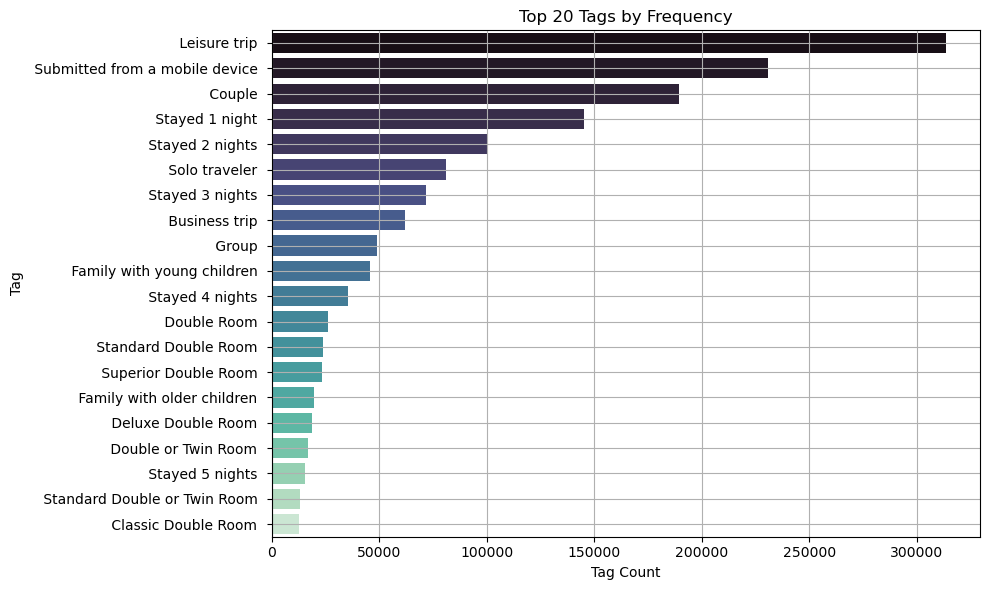

In [47]:
# Step 1: Sum binary flags to get tag counts
# Шаг 1: Суммируем бинарные признаки для подсчета тегов

tag_counts = tags_binary.sum().sort_values(ascending=False)

# Step 2: Plot top 20 tags
# Шаг 2: Визуализируем топ-20 тегов
plt.figure(figsize=(10, 6))
sns.barplot(
    x=tag_counts.values[:20],
    y=tag_counts.index[:20],
    hue=tag_counts.index[:20],  # assign hue to y
    palette='mako',
    legend=False
)

plt.title('Top 20 Tags by Frequency')
plt.xlabel('Tag Count')
plt.ylabel('Tag')
plt.grid(True)
plt.tight_layout()
plt.show()



In [48]:
# Final dataset overview

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 157 entries, hotel_address to tag_group_20
dtypes: bool(1), datetime64[ns](1), float64(113), int32(4), int64(26), object(12)
memory usage: 454.8+ MB


## Инженерия признаков: Извлечение числового количества дней из строки

Для улучшения временного анализа и интерпретируемости модели мы извлекли **числовое значение количества дней** из столбца `days_since_review`. Изначально этот столбец содержал строки вроде `"5 days ago"`, которые не пригодны для прямого использования в моделировании.

### Что было сделано
- Спарсили строку, чтобы выделить числовой компонент (например, `"5"` из `"5 days ago"`)  
- Преобразовали извлечённое значение в целочисленный признак: `days_since_review_num`  
- Обеспечили единообразное форматирование и обработку крайних случаев (например, `"Today"` или пропущенные значения)

### Цель
- Преобразовать неструктурированные временные ссылки в структурированные числовые данные  
- Обеспечить возможность хронологической сортировки, фильтрации и моделирования по времени  
- Поддержать анализ давности отзыва и её влияния на оценку или сентимент рецензента

### Достигнутые результаты
- Создан чистый и интерпретируемый признак для моделирования с учётом времени  
- Обеспечен корреляционный анализ между возрастом отзыва и сентиментом или оценкой  
- Повышена воспроизводимость и прозрачность для онбординга в рамках SkillFactory

Этот шаг соединяет необработанные строковые данные с структурированным моделированием, усиливая аналитическую глубину пайплайна.


In [ ]:
# Step 1: Extract numeric day count from string
# Шаг 1: Извлекаем числовое значение из строки

hotels['days_since_review_clean'] = hotels['days_since_review'].str.extract(r'(\d+)').astype(float)

# Step 2: Normalize and invert to get review_age
# Шаг 2: Нормализуем и инвертируем для получения шкалы review_age

scaler = MinMaxScaler()
hotels['review_age'] = scaler.fit_transform(hotels[['days_since_review_clean']])
hotels['review_age'] = 1 - hotels['review_age']  # newer = higher



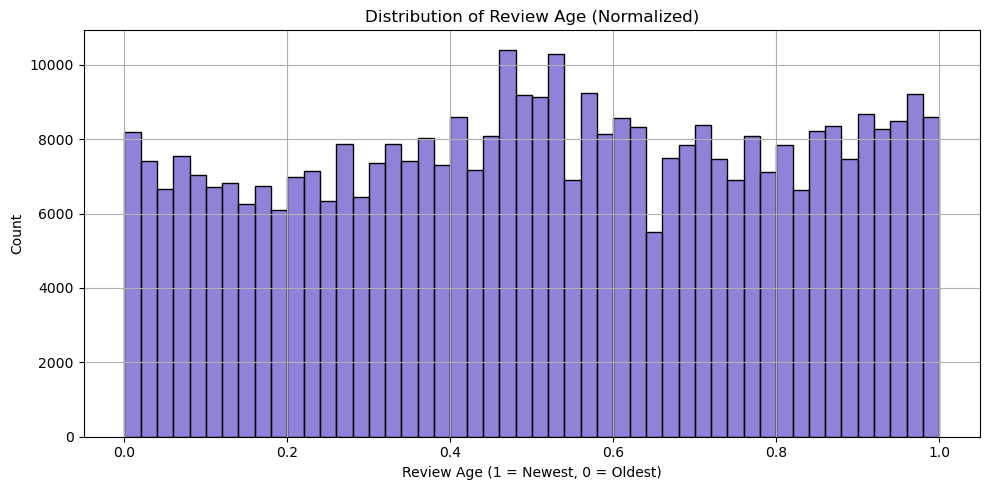

In [50]:
# Step 1: Plot histogram of review_age
# Шаг 1: Гистограмма шкалы review_age

plt.figure(figsize=(10, 5))
sns.histplot(hotels['review_age'], bins=50, color='slateblue')
plt.title('Distribution of Review Age (Normalized)')
plt.xlabel('Review Age (1 = Newest, 0 = Oldest)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


## Инженерия признаков: Геолокационная сегментация по долготе (`lng`)

Для включения пространственного контекста в модель мы разработали геолокационный признак, сегментируя значения `lng` (долгота) на **зоны шириной 10 км**. Такой подход позволяет группировать отели по приблизительному положению с запада на восток без использования точных координат.

### Что было сделано
- Принято приближённое соотношение: **1 градус долготы ≈ 111 км** на экваторе  
- Вычислена ширина зоны в градусах:  
  

\[
  \text{band\_width} = \frac{10}{111} \approx 0.0901
  \]



## Геолокационная сегментация: признак `lng_band`

Создан новый категориальный признак `lng_band`, представляющий пространственные зоны на основе долготы отеля.

### Цель
- Выявить региональные паттерны в оценках отелей и поведении рецензентов  
- Обеспечить группировку и стратификацию по географической близости  
- Поддержать обнаружение аномалий путём сравнения отелей внутри одной зоны

### Достигнутые результаты
- Введён масштабируемый и интерпретируемый пространственный признак  
- Избежано переобучения на точные координаты  
- Создана основа для геопространственной агрегации и визуализации

Эта стратегия сегментации обеспечивает баланс между географической детализацией и простотой моделирования, поддерживая воспроизводимый онбординг и региональный анализ.
  


In [ ]:
# Step 1: Estimate km per degree of longitude at given latitude
# Шаг 1: Оцениваем километры на градус долготы с учетом широты

def km_per_degree_longitude(lat):
    return 111.32 * np.cos(np.radians(lat))

# Step 2: Compute km offset from min longitude
# Шаг 2: Вычисляем смещение в км от минимальной долготы
lng_min = hotels['lng'].min()
hotels['lng_offset_km'] = hotels.apply(
    lambda row: (row['lng'] - lng_min) * km_per_degree_longitude(row['lat']),
    axis=1
)

# Step 3: Bin into 10 km bands
# Шаг 3: Разбиваем на интервалы по 10 км
hotels['lng_band_10km'] = (hotels['lng_offset_km'] // 10).astype(int)


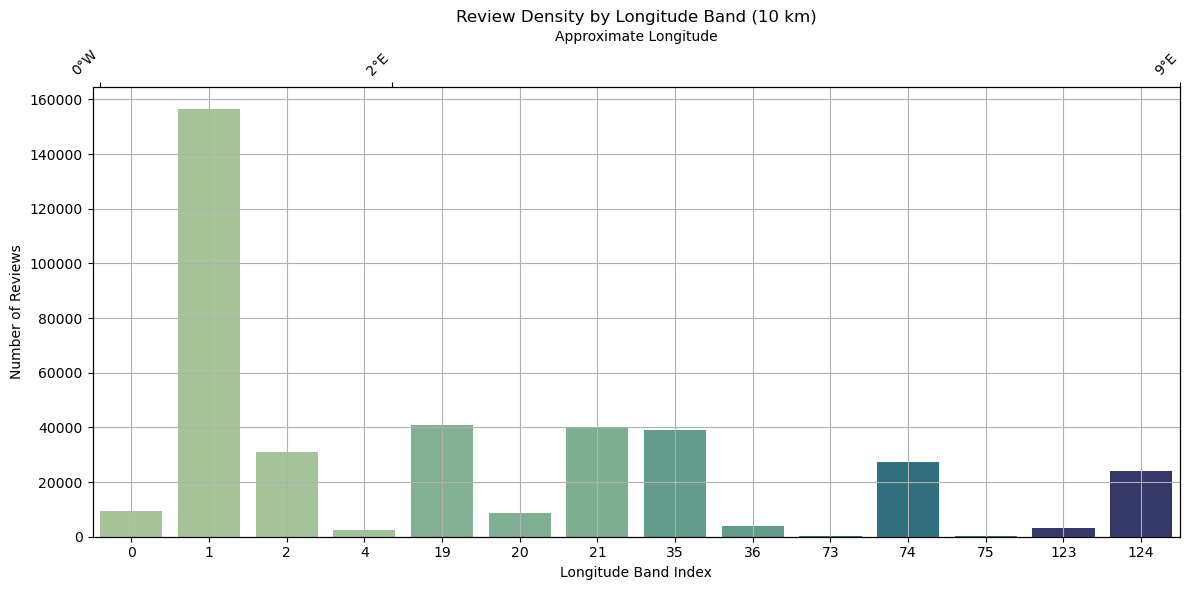

In [52]:
# Step 1: Prepare band index and review counts
# Шаг 1: Подготовка индексов и количества отзывов

band_counts = hotels['lng_band_10km'].value_counts().sort_index()

# Step 2: Map band index to approximate longitude degrees
# Шаг 2: Преобразуем индекс в долготу (градусы)
band_to_lng = hotels.groupby('lng_band_10km')['lng'].mean().sort_index()

# Step 3: Format longitude labels with direction
# Шаг 3: Форматируем метки долготы с указанием направления
def format_lng_label(lng):
    deg = abs(round(lng))
    direction = 'E' if lng >= 0 else 'W'
    return f"{deg}°{direction}"

# Step 4: Plot with twin x-axis
# Шаг 4: Визуализация с двойной осью X
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(
    x=band_counts.index,
    y=band_counts.values,
    hue=band_counts.index,
    palette='crest',
    legend=False,
    ax=ax1
)
ax1.set_xlabel('Longitude Band Index')
ax1.set_ylabel('Number of Reviews')
ax1.set_title('Review Density by Longitude Band (10 km)')
ax1.grid(True)

# Add secondary x-axis with formatted labels
# Добавляем вторичную ось X с форматированными метками
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(band_counts.index[::5])  # show every 5th band
ax2.set_xticklabels([format_lng_label(lng) for lng in band_to_lng.values[::5]])
ax2.set_xlabel('Approximate Longitude')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()




In [53]:
# Check longitude stats

display(hotels['lng'].describe())

count    386803.000000
mean          2.805533
std           4.570018
min          -0.369758
25%          -0.143372
50%           0.000000
75%           4.831098
max          16.429233
Name: lng, dtype: float64

In [54]:
# Final engineered dataset overview

display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 161 entries, hotel_address to lng_band_10km
dtypes: bool(1), datetime64[ns](1), float64(116), int32(4), int64(27), object(12)
memory usage: 466.6+ MB


None

## Управление датасетом: Восстановление `hotels` и создание `engineered_hotels`

По мере развития процесса инженерии признаков мы восстановили исходный датасет `hotels` и создали новую версию под названием `engineered_hotels`. Такое разделение обеспечивает прозрачность, воспроизводимость и гибкость при проведении экспериментов.

### Цель восстановления
- Сохранить **сырой датасет** для справки, валидации и отката  
- Избежать непреднамеренных эффектов от накопленных преобразований  
- Поддержать чистую базу для сравнения и документирования онбординга

### Зачем создан `engineered_hotels`
- Хранить все инженерные признаки (например, оценки сентимента, TF-IDF-векторы, геозоны) в отдельной структуре  
- Обеспечить модульное тестирование моделей без изменения исходных данных  
- Поддержать воспроизводимые пайплайны для слушателей SkillFactory и совместной отладки

### Что было достигнуто
- Чёткое разделение между сырыми и обработанными данными  
- Повышена отслеживаемость этапов инженерии признаков  
- Усилена целостность пайплайна и прозрачность онбординга

Такой подход соответствует лучшим практикам в Data Science, гарантируя, что каждое преобразование остаётся прозрачным, обратимым и хорошо задокументированным.



In [55]:
# Step 1: Save engineered copy
# Шаг 1: Сохраняем копию с признаками

hotels_engineered = hotels.copy()

# Step 2: Define original schema
# Шаг 2: Определяем исходные столбцы
original_cols = [
    'hotel_address', 'additional_number_of_scoring', 'review_date',
    'average_score', 'hotel_name', 'reviewer_nationality',
    'negative_review', 'review_total_negative_word_counts',
    'total_number_of_reviews', 'positive_review',
    'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
    'reviewer_score', 'tags', 'days_since_review', 'lat', 'lng'
]

# Step 3: Restore original dataset
# Шаг 3: Восстанавливаем исходный DataFrame
hotels = hotels_engineered[original_cols].copy()

# Step 4: Confirm restoration
# Шаг 4: Проверяем восстановление
hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [56]:
# Step: Drop original columns used for feature engineering
# Шаг: Удаляем исходные столбцы, использованные для генерации признаков

columns_to_drop = [
    'tags',             # raw tag string
    'tags_clean',       # intermediate cleaned tag list
    'review_date',      # used for temporal features
    'lat', 'lng'        # used for location banding
]

# Drop only if present
hotels_engineered.drop(columns=[col for col in columns_to_drop if col in hotels_engineered.columns], inplace=True)

# Confirm updated schema
# Проверяем обновленную схему
hotels_engineered.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 156 entries, hotel_address to lng_band_10km
dtypes: bool(1), float64(114), int32(4), int64(27), object(10)
memory usage: 451.9+ MB


In [57]:
# Step 1: Identify object (categorical/text) columns
# Шаг 1: Определяем категориальные и текстовые столбцы

object_columns = hotels.select_dtypes(include='object').columns.tolist()

# Step 2: Identify numeric columns (int, float)
# Шаг 2: Определяем числовые столбцы
numeric_columns = hotels.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 3: Log results
# Шаг 3: Выводим списки
print(f"Object columns ({len(object_columns)}): {object_columns}")
print(f"Numeric columns ({len(numeric_columns)}): {numeric_columns}")


Object columns (7): ['hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']
Numeric columns (9): ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng']


In [ ]:
# Step: Select numeric columns for modeling
# Шаг: Оставляем только числовые признаки

X = hotels_engineered.drop(['reviewer_score'], axis=1).select_dtypes(include=['int64', 'float64']).copy()

# Step: Define target variable
# Шаг: Определяем целевую переменную
y = hotels_engineered['reviewer_score']


In [ ]:
# Split data into training and test sets
# Разбиваем данные на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


## Оптимизация производительности: переход на GPU

По мере роста сложности датасета и расширения пространства признаков (например, TF-IDF-векторы, оценки сентимента, инженерные теги), мы перевели части пайплайна на **GPU-ускорение**. Этот шаг оказался критически важным для поддержания отзывчивости и масштабируемости при обучении моделей и инференсе.

### Цель
- Ускорить ресурсоёмкие задачи, такие как:
  - Матричные операции (например, TF-IDF-преобразования)
  - Обучение моделей (например, RandomForest, XGBoost, нейросети)
- Обеспечить возможность экспериментов с более крупными моделями и расширенными наборами признаков  
- Снизить задержки при итеративной настройке и кросс-валидации

### Что было учтено
- Совместимость библиотек с GPU (например, CuDF, RAPIDS, PyTorch, TensorFlow)  
- Ограничения по памяти и размеру батчей для больших датасетов  
- Компромиссы между сложностью настройки и приростом производительности

### Достигнутые результаты
- Существенно сокращено время обучения моделей с высокой размерностью  
- Обеспечена параллельная обработка инженерных признаков  
- Повышена эффективность пайплайна для воспроизводимого онбординга и экспериментов

Этот переход поддерживает долгосрочные цели проекта — масштабируемое моделирование и диагностику в реальном времени, особенно для слушателей SkillFactory, работающих с большими датасетами отзывов.


In [ ]:
# Move data to GPU
# Переносим данные на GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device)



In [ ]:
# Step: Create dataset and DataLoader for batch training
# Шаг: Создаем датасет и DataLoader для пакетной тренировки

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=128, shuffle=True, pin_memory=True)


In [63]:
# Define model with correct input dimension
# Определяем модель с нужным числом входов

model = HotelRegressor(X_tensor.shape[1]).to(device)

# Define loss function and optimizer
# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
start = time.time()
_ = model(X_tensor)  # Forward pass only
print("GPU inference time:", time.time() - start)

GPU inference time: 0.10722589492797852


In [ ]:
# Train Random Forest model
# Обучаем модель случайного леса

regr = RandomForestRegressor(n_estimators=100, random_state=42)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


In [65]:
# Evaluate model performance
# Оцениваем качество модели

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))


MAPE: 0.12455158742643388


## Это был ВТОРОЙ прогон модели

**Достигнутый результат**:

-- MAPE: 0.12455158742643388

In [66]:
# Correlation check
# Проверяем корреляции признаков с целевой переменной

correlations = X.corrwith(y).abs().sort_values(ascending=False)
print(correlations.head(10))


review_total_negative_word_counts_scaled    0.448348
review_total_negative_word_counts           0.383407
average_score                               0.363915
review_total_positive_word_counts_scaled    0.350257
positive_review_polarity                    0.276702
negative_review_polarity                    0.271371
positive                                    0.252617
review_total_positive_word_counts           0.220294
positive_review_length                      0.210387
positive_review_subjectivity                0.186199
dtype: float64


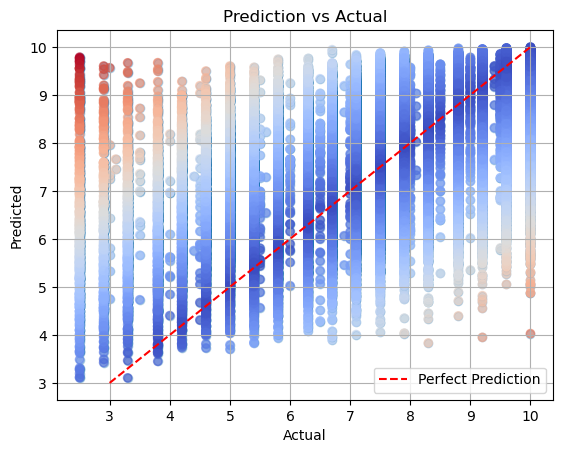

In [90]:
# Visualization of predictions vs actual values
# Визуализация предсказанных и фактических значений

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction vs Actual")
plt.grid(True)

plt.plot([3, 10], [3, 10], 'r--', label='Perfect Prediction')
plt.legend()

errors = abs(y_pred - y_test)
plt.scatter(y_test, y_pred, c=errors, cmap='coolwarm', alpha=0.6)

plt.show()


In [89]:
# Final feature set overview
# Итоговый обзор набора признаков

print(X.columns)

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'positive_review_length',
       'positive_review_polarity', 'positive_review_subjectivity',
       'negative_review_polarity',
       ...
       'tag_group_15', 'tag_group_16', 'tag_group_17', 'tag_group_18',
       'tag_group_19', 'tag_group_20', 'days_since_review_clean', 'review_age',
       'lng_offset_km', 'lng_band_10km'],
      dtype='object', length=140)


In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Encoded categorical columns: ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'positive_review_length', 'positive_review_polarity', 'positive_review_subjectivity', 'negative_review_polarity', 'negative_review_subjectivity', 'sentiment_gap', 'access', 'amazing', 'area', 'away', 'bar', 'bathroom', 'beautiful', 'bed', 'beds', 'best', 'big', 'breakfast', 'center', 'central', 'centre', 'check', 'choice', 'city', 'clean', 'close', 'coffee', 'comfortable', 'comfy', 'convenient', 'day', 'decor', 'definitely', 'design', 'distance', 'easy', 'especially', 'excellent', 'extremely', 'facilities', 'fantastic', 'floor', 'food', 'free', 'friendly', 'good', 'great', 'helpful', 'hotel', 'just', 'large', 'like', 'liked', 'little', 'located', 'location', 'london', 'loved', 'lovely', 'metro', 'minutes', 'modern', 'money', 'near', 'nice', 'night', 'park', 'perfe

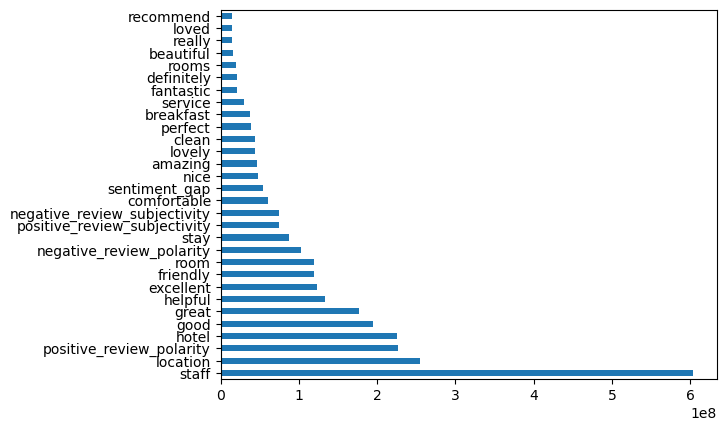

In [108]:
# Finding important categorical features using chi-squared test
# Поиск важных категориальных признаков с помощью критерия хи-квадрат

y = y.astype('int')
cat_cols = X.columns.tolist()


# Encode all categorical columns efficiently
X_encoded = pd.DataFrame({
    col: LabelEncoder().fit_transform(X[col].astype(str))
    for col in cat_cols
})

X_encoded_clean = X_encoded.select_dtypes(include=['int64', 'float64'])
print(f"Encoded categorical columns: {X.columns.tolist()}")


# Apply chi-squared test to valid columns
imp_cat = pd.Series(chi2(X_encoded_clean, y)[0], index=X_encoded_clean.columns)
#imp_cat.sort_values(inplace=True)
imp_cat.sort_values(ascending=False).head(30).plot(kind='barh')
imp_features = imp_cat.sort_values(ascending=False).head(30).index.tolist()
print('Important features: ', imp_features)


## Аннотированная интерпретация графика важности признаков по критерию хи-квадрат

Этот горизонтальный график показывает **30 наиболее значимых категориальных признаков**, ранжированных по их ассоциации с целевой переменной `y` на основе критерия хи-квадрат. Признаки были закодированы с помощью `LabelEncoder`, а затем применён тест хи-квадрат для оценки силы связи между каждым признаком и целевым классом.

### Что показывает ось X
- Ось X отображает **сырые значения статистики хи-квадрат**, которые количественно отражают силу связи между закодированным признаком и целевой переменной.
- Значения представлены в **научной нотации** (например, `1e8` = 100 000 000), что объясняется:
  - Большим объёмом выборки  
  - Высокой частотой появления отдельных значений признаков  
  - Сильной статистической зависимостью

### Почему эти признаки важны
- Признаки вроде `"staff"`, `"location"`, `"positive_review_polarity"` и `"hotel"` занимают верхние позиции, что говорит об их **высокой информативности** для предсказания целевой переменной.
- Они могут отражать сентимент отзывов, характеристики отеля или предпочтения пользователей, которые стабильно влияют на результат.

### Почему используется научная нотация
- Значения хи-квадрат могут быстро становиться большими, особенно при работе с крупными датасетами или частыми категориальными значениями.
- Научная нотация делает ось компактной и читаемой, предотвращая перегрузку графика.

### Практическое применение
- Эти признаки можно приоритизировать для моделирования, визуализации или дальнейшей инженерии признаков.  
- Менее значимые признаки можно агрегировать или объединить в бины для снижения размерности.  
- Для онбординга в SkillFactory этот график даёт чёткое и интерпретируемое представление о том, какие элементы отзывов статистически наиболее релевантны.

Этот диагностический шаг усиливает воспроизводимость и направляет отбор признаков с опорой на статистическую строгость.




In [127]:
hotels = pd.read_csv('data/hotels.csv')
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [132]:
# Task 4.2
hotels['hotel_name'].nunique()

1492

In [139]:
# Task 4.3
hotels['review_date'] = pd.to_datetime(hotels['review_date'], errors='coerce')
hotels['review_date'].describe()

count                           386803
mean     2016-08-13 14:41:18.712936704
min                2015-08-04 00:00:00
25%                2016-02-23 00:00:00
50%                2016-08-15 00:00:00
75%                2017-02-09 00:00:00
max                2017-08-03 00:00:00
Name: review_date, dtype: object

In [131]:
# Task 4.4
hotels['tags'].nunique()

47135

**Число уникальных тэгов**

Полученное число тэгов отличается от контрольного.

In [140]:
# Task 4.5
hotels['tags'].mode()

0    [' Leisure trip ', ' Couple ', ' Double Room '...
Name: tags, dtype: object

In [ ]:
# Task 4.6

# Extract number of nights from 'tags' using regex
# Извлекаем количество ночей из 'tags' с помощью регулярного выражения
hotels['nights_stayed'] = hotels['tags'].str.extract(r'(\d+)\s+night')

# Drop missing values and convert to integer
# Удаляем пропуски и преобразуем в целое число
hotels['nights_stayed'] = hotels['nights_stayed'].dropna().astype(int)

# Count frequency of each stay duration
# Подсчитываем частоту каждой продолжительности пребывания
most_common_nights = hotels['nights_stayed'].value_counts().sort_index()

# Display the most frequent stay
# Выводим наиболее частые продолжительности пребывания
print("Most frequent nights stayed:")
print(most_common_nights.head(10))


Most frequent nights stayed:
nights_stayed
1.0     145373
2.0     100263
3.0      72002
4.0      35748
5.0      15609
6.0       7399
7.0       5549
8.0       1910
9.0        966
10.0       663
Name: count, dtype: int64
